In [118]:
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt

In [189]:
data = pd.read_csv('../data/amsterdam_weekdays.csv')

data["person_capacity"] = data["person_capacity"].astype(int)
data["cleanliness_rating"] = data["cleanliness_rating"].astype(int)
data["host_is_superhost"] = data["host_is_superhost"].astype(str)
data["realSum"] = data["realSum"].clip(0, 4000)

data["dist"] *= 1000
data["metro_dist"] *= 1000

In [190]:
data.head()

,realSum,room_type,person_capacity,host_is_superhost,cleanliness_rating,bedrooms,dist,metro_dist
0,194.033698,Private room,2,False,10,1,5022.963798,2539.380003
1,344.245776,Private room,4,False,8,1,488.389289,239.403923
2,264.101422,Private room,2,False,9,1,5748.311915,3651.621289
3,433.529398,Private room,4,False,9,2,384.862013,439.876076
4,485.552926,Private room,2,True,10,1,544.738183,318.692647


## Анализ переменных

In [191]:
numerical_columns = [
    'realSum',
    'person_capacity',
    'cleanliness_rating',
    'bedrooms',
    'dist',
    'metro_dist'
]

categorical_columns = [
    'room_type',
    'host_is_superhost'
]

In [192]:
def describe_column(dataframe, column_name):
    data = dataframe[column_name]
    cnt, mean, std, *quartiles = data.describe()
    x_min, lower_quartile, x_median, upper_quartile, x_max = quartiles
    interquartile_range = upper_quartile - lower_quartile
    skewness = sps.skew(data)
    kurtosis = sps.kurtosis(data)
    return {
        "variable": column_name,
        "cnt": cnt,
        "mean": mean,
        "std": std,
        "x_min": x_min,
        "lower_quartile": lower_quartile,
        "upper_quartile": upper_quartile,
        "x_min": x_min,
        "x_max": x_max,
        "x_median": x_median,
        "skewness": skewness,
        "kurtosis": kurtosis,
        "interquartile_range": interquartile_range,
    }

In [193]:
stat_dicts = []
for col in numerical_columns:
    stat_dicts.append(describe_column(data, col))

column_stats = pd.DataFrame(stat_dicts).set_index('variable').T

In [194]:
column_stats

variable,realSum,person_capacity,cleanliness_rating,bedrooms,dist,metro_dist
cnt,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000
mean,541.590873,2.792384,9.461469,1.282865,2841.621295,1089.438652
std,370.337288,1.044151,0.798201,0.740178,2123.244864,836.546486
x_min,128.887118,2.000000,4.000000,0.000000,15.058798,36.529935
lower_quartile,309.797764,2.000000,9.000000,1.000000,1302.058280,462.982766
upper_quartile,657.324303,4.000000,10.000000,2.000000,3648.138498,1510.629489
x_max,4000.000000,6.000000,10.000000,5.000000,11187.100154,4411.915315
x_median,430.248635,2.000000,10.000000,1.000000,2341.365645,856.009791
skewness,3.156500,0.934017,-2.059010,1.134377,1.454982,1.367371
kurtosis,17.143227,-0.120154,6.708298,2.125365,2.261120,1.796988


### Графики для количественных переменных

In [195]:
def plot_hist_density(dataframe, column_name, ax):
    data = dataframe[column_name]
    _, mu, sigma, *_ = data.describe()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    density = sps.norm.pdf(x, mu, sigma)
    sns.histplot(data, ax=ax, stat='density')
    sns.lineplot(x=x, y=density, color='red', ax=ax, label=f'$Norm$({mu:.1f}, {sigma:.1f})')

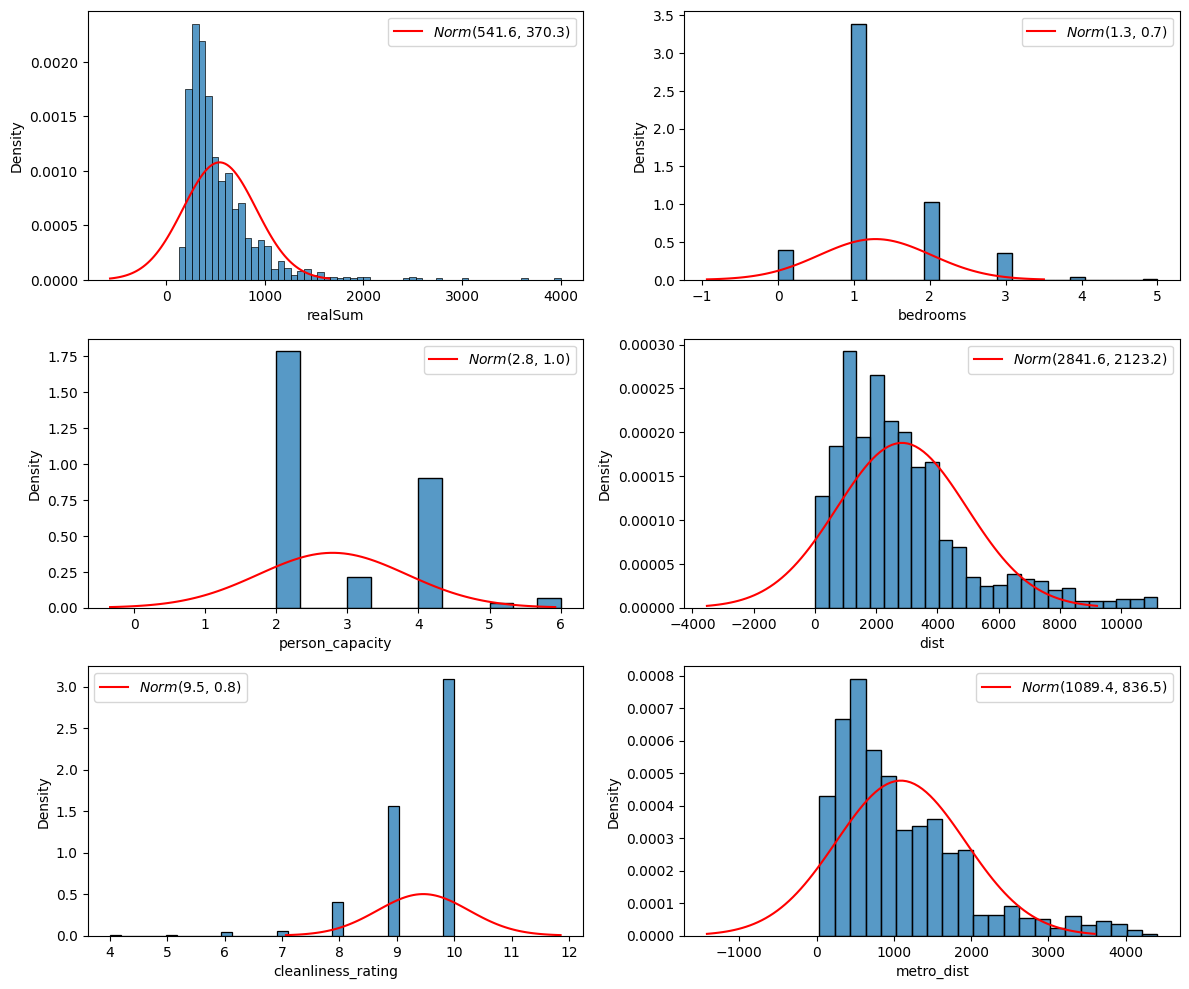

In [196]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i in range(6):
    col = numerical_columns[i]
    plot_hist_density(data, col, ax[i%3][i//3])

plt.tight_layout()
plt.show()

### Номинальные переменные

In [197]:
cat_variable_stats = []

for col in categorical_columns:
    group_cnts = data[col].value_counts()
    group_freqs = group_cnts / group_cnts.sum()
    cat_variable_stats.append(pd.DataFrame({"cnt": group_cnts, "freqs": group_freqs}))

In [198]:
cat_variable_stats[0]

,cnt,freqs
room_type,,
Private room,559,0.506800
Entire home/apt,538,0.487761
Shared room,6,0.005440


In [199]:
cat_variable_stats[1]

,cnt,freqs
host_is_superhost,,
False,780,0.707162
True,323,0.292838


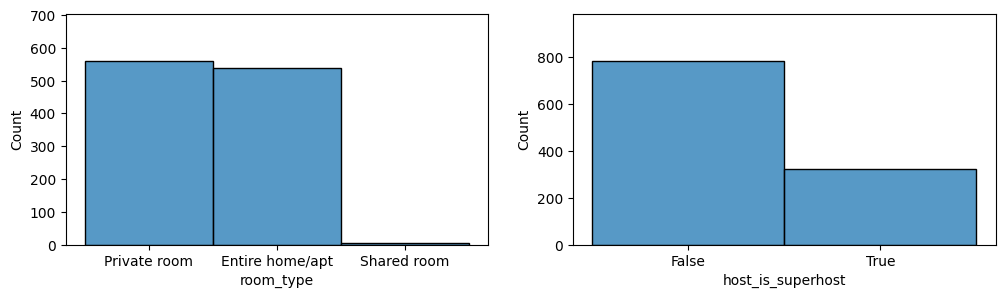

In [200]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 3))

sns.histplot(data[categorical_columns[0]], ax=ax[0])
l, h = ax[0].get_ylim()
ax[0].set_ylim(l, h * 1.2)

sns.histplot(data[categorical_columns[1]], ax=ax[1])
l, h = ax[1].get_ylim()
ax[1].set_ylim(l, h * 1.2)

plt.show()

## Анализ статистической связи.

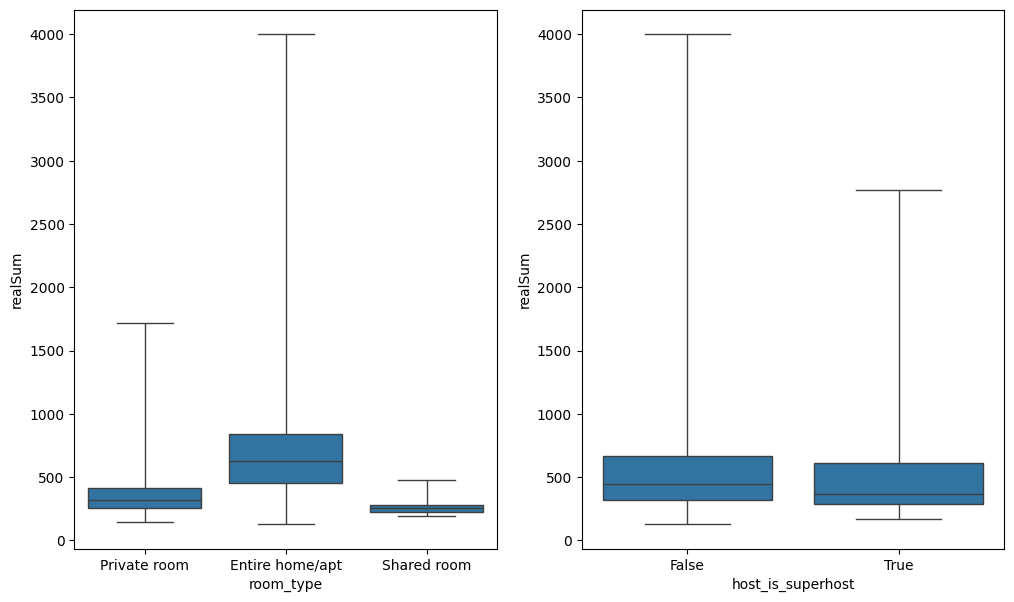

In [206]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 7))

for i in range(2):
    col = categorical_columns[i]
    sns.boxplot(data=data, x=col, y="realSum", ax=ax[i], whis=(0, 100))

plt.show()

In [216]:
for i in range(2):
    col = categorical_columns[i]
    subsets = []
    for val in data[col].unique():
        subsets.append(data["realSum"][data[col] == val])
    print(f'Kruskal test for {col}')
    test_res = sps.kruskal(*subsets)
    print(f'Null hypothesis is rejected: {test_res.pvalue < 0.05}')
    print()

Kruskal test for room_type
Null hypothesis is rejected: True

Kruskal test for host_is_superhost
Null hypothesis is rejected: True



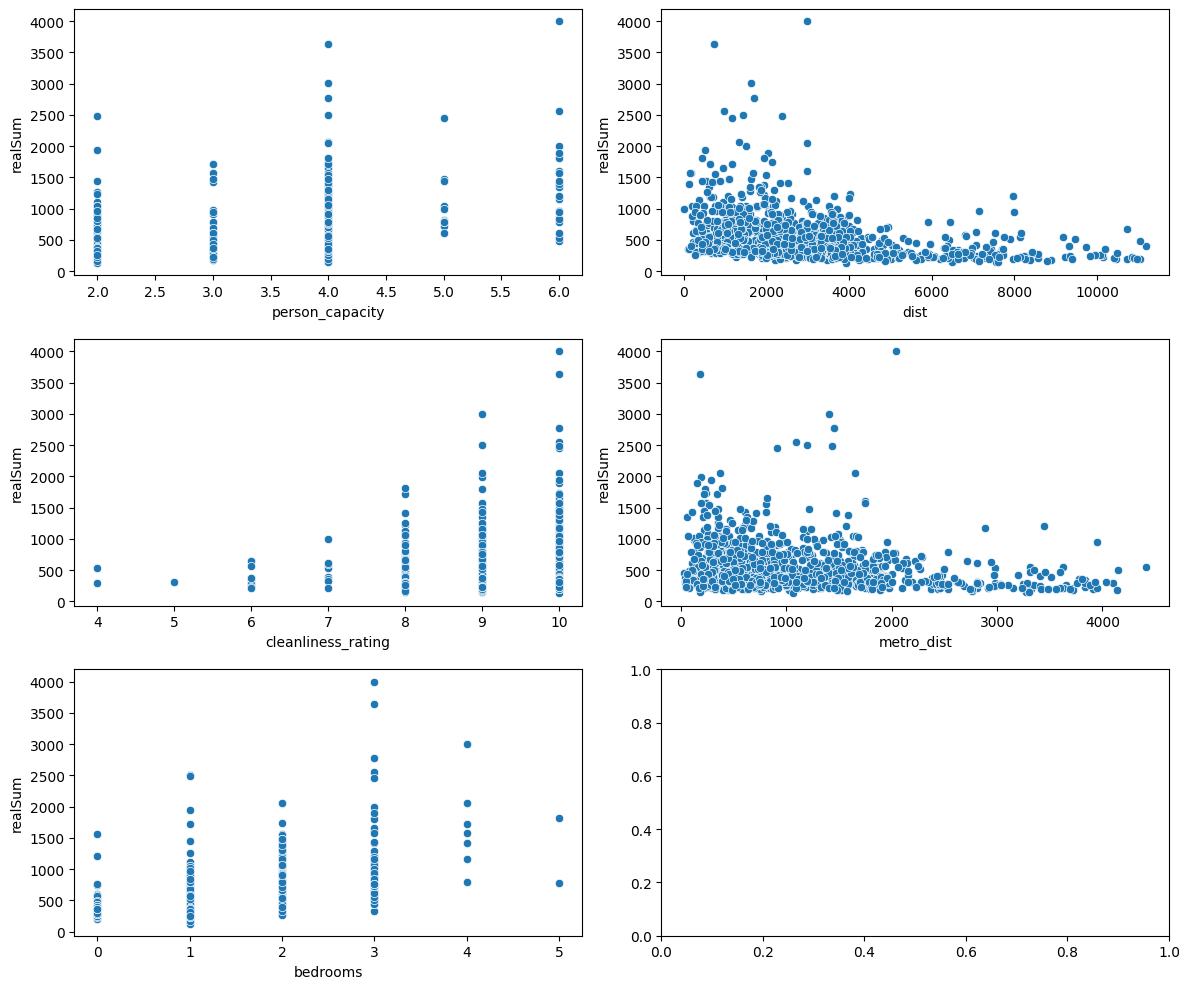

In [211]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 10))

for i in range(5):
    col = numerical_columns[1:][i]
    sns.scatterplot(data=data, x=col, y="realSum", ax=ax[i%3][i//3])

plt.tight_layout()
plt.show()